### **This Notebook Evaluates Group KFold Cross-Validation to Better Measure how the model generalises**

Group KFold Cross-Validation prevents spectra from the same Surface appearing within both the training and test folds.

This gives a better indication of the model's ability to generalise, as it stops leakage between samples from the same fold.

Import Libraries

In [129]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.model_selection import LeavePGroupsOut

Read the spectral data

In [130]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Filter the effective range from 380/400 to 1800 cm-1

In [131]:
#df = df[(df['WaveNumber'] >= 320) & (df['WaveNumber'] <= 1800)]
#df = df[(df['WaveNumber'] >= 380) & (df['WaveNumber'] <= 1800)]
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [132]:
#df.to_csv("../../data/exosomes.raw_spectrum_400-1800.csv", index=False)

In [133]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [134]:
df['SpecID'].unique()

array(['201210-1-00', '201210-1-01', '201210-1-02', ..., '210526-3-07',
       '210526-3-08', '210526-3-09'], dtype=object)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6239205 entries, 293 to 8023281
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 333.2+ MB


#### Train an Extra Trees Classifier on the full spectrum.

In [136]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [137]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [138]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,201210-1,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,201210-1,Normal
201210-1-02,2182.6694,2149.6565,2146.0227,2159.3459,2167.2910,2160.9861,2145.6575,2134.2004,2142.8303,2138.6309,...,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,201210-1,Normal
201210-1-03,2445.0837,2430.4973,2422.7927,2434.3433,2454.9700,2462.8245,2454.7007,2467.7329,2449.5161,2421.3474,...,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,201210-1,Normal
201210-1-04,2250.4536,2248.6235,2245.0984,2242.7173,2235.2803,2228.9585,2236.0095,2229.6091,2225.9231,2211.0359,...,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,201210-1,Normal


>**The Count of Surface IDs and the number of associated samples**

In [139]:
len(wavelength_df.groupby(['SurID']))

63

In [140]:
wavelength_df.groupby(['SurID', 'Status']).size().reset_index(name='Count of Spectra per Surface')

,SurID,Status,Count of Spectra per Surface
0,201210-1,Normal,49
1,201210-2,Normal,50
2,210114-1,Normal,50
3,210114-2,Normal,50
4,210120-1,Hyperglycemia,50
...,...,...,...
58,210519-3,Hyperglycemia,50
59,210524-1,Hypoglycemia,15
60,210526-1,Hyperglycemia,50
61,210526-2,Hyperglycemia,15


It looks like each Surface is associated with 1 Status

>**The Count of Spectra with each Status**

In [141]:
df.groupby('Status')['SpecID'].nunique().reset_index(name='Spectra Count')

,Status,Spectra Count
0,Hyperglycemia,915
1,Hypoglycemia,1065
2,Normal,1065


>**The Count of Surfaces with each Status**

In [142]:
df.groupby('Status')['SurID'].nunique().reset_index(name='Surface Count')

,Status,Surface Count
0,Hyperglycemia,19
1,Hypoglycemia,22
2,Normal,22


>#### **Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with GroupKFold cross-validation.**

Ensures that spectra from the same surface are not contained within the same CV folds out to evaluate the models ability to generalise on independent samples.

In [143]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = []
    for train_index, test_index in cv.split(X, y, groups):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the Extra Trees classifier
        et.fit(X_train, y_train)
        predictions = et.predict(X_test)
        
        # Evaluate the model
        score = accuracy_score(y_test, predictions)
        scores.append(score)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [144]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5350 +/- 0.1277


>Scale the absorbances to the highest peak in each spectrum.

In [145]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [146]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755


In [147]:
scaled_raw_df = prepare_wavelength_df(df, 'Scaled_Absorbance')

In [148]:
scaled_raw_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.953424,0.958347,0.955242,0.948434,0.949755,0.952110,0.942389,0.957576,0.958312,0.946763,...,0.653646,0.655516,0.661592,0.653377,0.653747,0.644989,0.645355,0.642506,201210-1,Normal
201210-1-01,0.966924,0.964678,0.960813,0.960696,0.965006,0.970900,0.972982,0.965186,0.967645,0.965453,...,0.679699,0.670361,0.668847,0.665616,0.665119,0.665591,0.669153,0.673599,201210-1,Normal
201210-1-02,0.590483,0.581552,0.580569,0.584174,0.586323,0.584617,0.580471,0.577371,0.579706,0.578570,...,0.534629,0.538094,0.540060,0.535479,0.534627,0.539708,0.534086,0.533271,201210-1,Normal
201210-1-03,0.708234,0.704009,0.701777,0.705123,0.711097,0.713373,0.711019,0.714794,0.709518,0.701358,...,0.577106,0.585868,0.579843,0.582236,0.581193,0.584320,0.590369,0.579500,201210-1,Normal
201210-1-04,0.915371,0.914627,0.913193,0.912225,0.909200,0.906628,0.909496,0.906893,0.905394,0.899338,...,0.817176,0.794517,0.798681,0.799072,0.801119,0.808060,0.801357,0.816381,201210-1,Normal


In [149]:
#scaled_raw_df.to_csv("../../data/scaled_raw_spectra.csv")

In [150]:
evaluate_extra_trees(scaled_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4987 +/- 0.0945


> Now see the effect of removing spikes caused by cosmic rays

Locate and correct the spikes

In [151]:
# https://towardsdatascience.com/data-science-for-raman-spectroscopy-a-practical-example-e81c56cf25f

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=20) # Tuned based on ml performance
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [152]:
# # Doing this to check the combination
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [153]:
despiked_df = prepare_wavelength_df(df, 'Despiked_Absorbance')

In [154]:
evaluate_extra_trees(despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5432 +/- 0.1365


Despike with scaling.

In [155]:
df['Scaled_Despiked_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: normalise(x))

In [156]:
scaled_despiked_df = prepare_wavelength_df(df, 'Scaled_Despiked_Absorbance')

In [157]:
evaluate_extra_trees(scaled_despiked_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4926 +/- 0.1003


This seems to cause a small degradation to performance.

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [158]:
# def baseline_als_optimized(y, lam, p, niter=10):
#     L = len(y)
#     D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
#     D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
#     w = np.ones(L)
#     W = sparse.spdiags(w, 0, L, L)
#     for i in range(niter):
#         W.setdiag(w) # Do not create a new matrix, just update diagonal values
#         Z = W + D
#         z = spsolve(Z, w*y)
#         w = p * (y > z) + (1-p) * (y < z)
#     return z

# lam = 10 ** 8
# p = 0.05
# df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

In [159]:
from pybaselines.whittaker import asls

def asls_baseline_correction(x, lam, p):
        corrected, _ = asls(x, lam=lam, p=p)
        return corrected

The PyBaselines Library Performs this much faster.

Here is an example on 1 spectrum

In [160]:
sample = df[df['SpecID'] == "210526-3-06"]
sample

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance
8013328,210526-3-06,293,400.22778,2367.7305,210526-3,Hyperglycemia,0.832666,2367.7305,0.832666
8013329,210526-3-06,294,400.91116,2352.8223,210526-3,Hyperglycemia,0.827424,2352.8223,0.827424
8013330,210526-3-06,295,401.59454,2377.9473,210526-3,Hyperglycemia,0.836259,2377.9473,0.836259
8013331,210526-3-06,296,402.27789,2394.0313,210526-3,Hyperglycemia,0.841916,2394.0313,0.841916
8013332,210526-3-06,297,402.96127,2376.4995,210526-3,Hyperglycemia,0.835750,2376.4995,0.835750
...,...,...,...,...,...,...,...,...,...
8015372,210526-3-06,2337,1797.03870,1967.4805,210526-3,Hyperglycemia,0.691909,1967.4805,0.691909
8015373,210526-3-06,2338,1797.72200,1965.0815,210526-3,Hyperglycemia,0.691066,1965.0815,0.691066
8015374,210526-3-06,2339,1798.40550,1947.5498,210526-3,Hyperglycemia,0.684900,1947.5498,0.684900
8015375,210526-3-06,2340,1799.08890,1951.8849,210526-3,Hyperglycemia,0.686425,1951.8849,0.686425


/tmp/ipykernel_14817/378197026.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

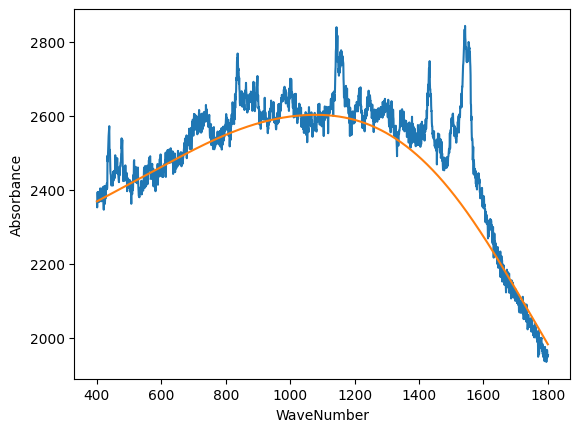

In [221]:
# lam = 10 ** 6
# p = 0.01

# lam = 10 ** 7
# p = 0.05

lam = 10 ** 9
p = 0.1
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

/tmp/ipykernel_14817/1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

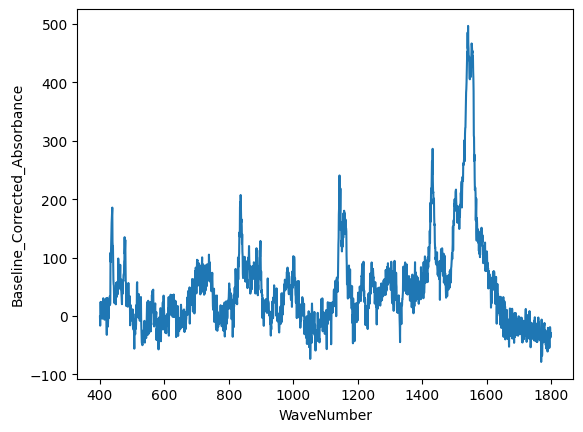

In [222]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Remove the noise from the spectra using Savitzky–Golay-filtering on the raw spectrum.

/tmp/ipykernel_14817/2008908675.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

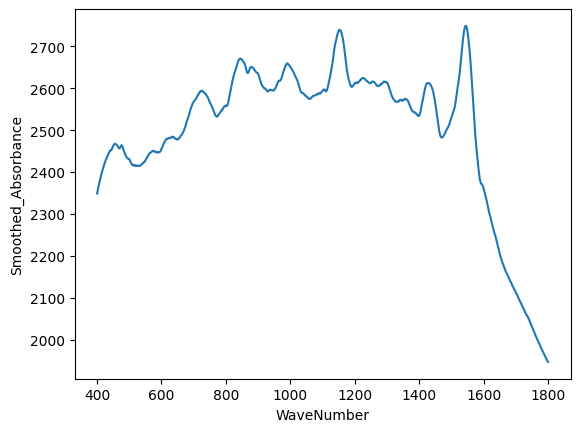

In [223]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

Try it on the Baseline_Corrected_Spectrum

/tmp/ipykernel_14817/1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

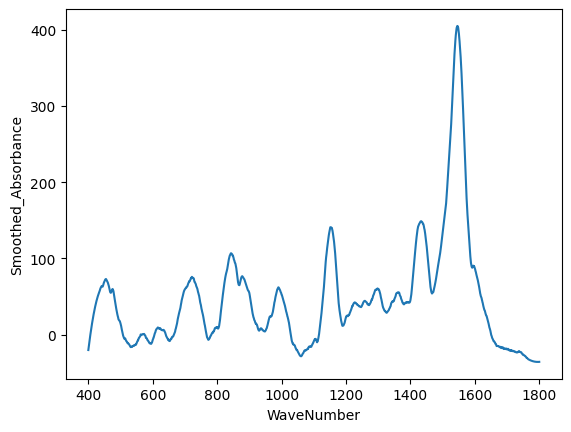

In [224]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

/tmp/ipykernel_14817/1280720429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))


<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

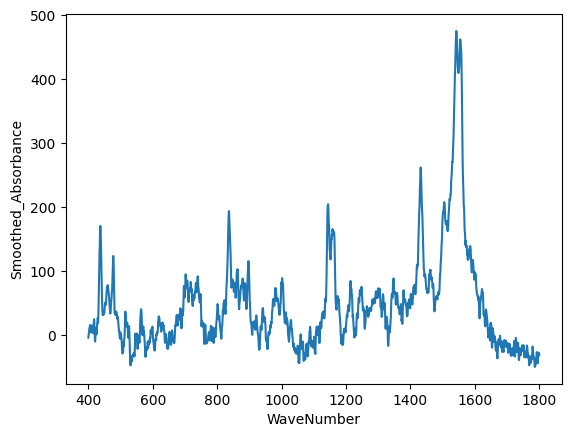

In [225]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, 9, 2, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

>Based on hand tuned parameters lets see how they affect the Machine Learning Classification.

In [226]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [227]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Scaled_Absorbance,Despiked_Absorbance,Scaled_Despiked_Absorbance,Baseline_Corrected_Absorbance,...,Smoothed_Absorbance,Scaled_Smooth,Smoothed_Baseline,Scaled_Smooth_Baseline,Vector_Scaled_Absorbance,No_Below_Baseline,Scaled_No_Below_Baseline,MinMax_Absorbance,MinMax_Baseline,Vector_Scaled_Baseline
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.953424,1765.6628,0.953424,28.724268,...,1766.369021,0.980552,25.471999,0.012257,0.024759,24.824567,0.128976,0.869714,0.262185,0.011220
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.958347,1774.7809,0.958347,37.986485,...,1765.961912,0.980326,25.407718,0.012226,0.024886,34.279384,0.178098,0.883487,0.303795,0.015494
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.955242,1769.0302,0.955242,32.379903,...,1765.561221,0.980103,25.349628,0.012198,0.024806,28.865400,0.149970,0.874801,0.279969,0.013047
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.948434,1756.4220,0.948434,19.915820,...,1765.166948,0.979885,25.297728,0.012173,0.024629,16.593916,0.086213,0.855756,0.225963,0.007500
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.949755,1758.8690,0.949755,22.506938,...,1764.779094,0.979669,25.252020,0.012151,0.024663,19.377630,0.100676,0.859453,0.238214,0.008759


In [228]:
baseline_corrected_df = prepare_wavelength_df(df, 'Baseline_Corrected_Absorbance')

In [229]:
baseline_corrected_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,28.724268,37.986485,32.379903,19.915820,22.506938,27.012055,9.154672,37.423690,38.931007,17.686624,...,-14.901671,-10.984931,0.722611,-14.037547,-12.898606,-28.662363,-27.531021,-32.353679,201210-1,Normal
201210-1-01,37.325252,32.947002,25.275953,25.228203,34.188153,46.368203,50.794754,35.125704,40.319354,36.051704,...,3.862698,-14.633327,-17.211851,-23.284276,-23.793000,-22.332424,-14.586748,-5.041072,201210-1,Normal
201210-1-02,129.723421,96.757098,93.169875,106.539653,114.531330,108.273007,92.990984,81.580460,90.256937,86.104112,...,-46.003900,-32.901519,-25.344937,-41.986955,-44.846373,-25.771590,-46.261407,-48.985324,201210-1,Normal
201210-1-03,172.235000,157.699680,150.046159,161.647839,182.325619,190.231199,182.158478,195.241757,177.076035,148.958413,...,-82.875963,-51.731568,-71.640571,-62.484074,-65.192376,-53.503578,-31.729780,-68.359182,201210-1,Normal
201210-1-04,98.459476,96.786008,93.417540,91.193073,83.912705,77.747537,84.955169,78.711401,75.182032,60.451463,...,-41.791709,-97.055339,-86.371268,-84.966596,-79.488524,-61.980751,-78.014378,-40.633405,201210-1,Normal


In [230]:
evaluate_extra_trees(baseline_corrected_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5774 +/- 0.1149


Scale the Baseline Corrected Absorbances to the highest peak.

In [231]:
df['Scaled_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: normalise(x))

In [232]:
scaled_baseline_df = prepare_wavelength_df(df, 'Scaled_Baseline_Corrected')

In [233]:
evaluate_extra_trees(scaled_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5683 +/- 0.1104


> Lets try 2 different Savitsky Golay Approaches on the Raw and Baseline Corrected Spectra with and without scaling

In [234]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [235]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [236]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5353 +/- 0.1264


In [237]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [238]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [239]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4944 +/- 0.0942


In [240]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [241]:
smooth_df = prepare_wavelength_df(df, 'Smoothed_Absorbance')

In [242]:
evaluate_extra_trees(smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5296 +/- 0.1278


In [243]:
df['Scaled_Smooth'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

In [244]:
scaled_smooth_df = prepare_wavelength_df(df, 'Scaled_Smooth')

In [245]:
evaluate_extra_trees(scaled_smooth_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.4890 +/- 0.0876


Try this on the baseline corrected spectra.

In [246]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [247]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [248]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5807 +/- 0.1159


In [249]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [250]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [251]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5802 +/- 0.1107


In [252]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 101
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [253]:
smooth_baseline = prepare_wavelength_df(df, 'Smoothed_Baseline')

In [254]:
evaluate_extra_trees(smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5800 +/- 0.1003


In [255]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: normalise(x))

In [256]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [257]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5663 +/- 0.1097


This is worse, lets try vector normalisation, where the spectra are scaled by their euclidean norm.

In [258]:
def vector_normalise(absorbances):
    l2_norm = np.sqrt(np.sum(absorbances**2))  # Calculate the euclidean norm
    normalized_absorbances = absorbances / l2_norm
    return normalized_absorbances

df['Vector_Scaled_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))

In [259]:
df['Scaled_Smooth_Baseline'] = df.groupby('SpecID')['Smoothed_Baseline'].transform(lambda x: vector_normalise(x))

In [260]:
scaled_smooth_baseline = prepare_wavelength_df(df, 'Scaled_Smooth_Baseline')

In [261]:
evaluate_extra_trees(scaled_smooth_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5751 +/- 0.1114


----

In [262]:
df['No_Below_Baseline'] = np.where(df['Baseline_Corrected_Absorbance'] < 0, 0, df['Baseline_Corrected_Absorbance'])

In [263]:
no_negative = prepare_wavelength_df(df, 'No_Below_Baseline')

In [264]:
evaluate_extra_trees(no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5866 +/- 0.1161


Then with scaling.

In [265]:
df['Scaled_No_Below_Baseline'] = np.where(df['Scaled_Baseline_Corrected'] < 0, 0, df['Scaled_Baseline_Corrected'])

In [266]:
scaled_no_negative = prepare_wavelength_df(df, 'Scaled_No_Below_Baseline')

In [267]:
scaled_no_negative.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.162081,0.214345,0.182709,0.112378,0.126999,0.152420,0.051657,0.211169,0.219674,0.099800,...,0.000000,0.0,0.004077,0.0,0.0,0.0,0.0,0.0,201210-1,Normal
201210-1-01,0.164229,0.144965,0.111213,0.111003,0.150426,0.204018,0.223494,0.154551,0.177403,0.158626,...,0.016996,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,201210-1,Normal
201210-1-02,0.080517,0.060055,0.057829,0.066127,0.071087,0.067203,0.057718,0.050635,0.056021,0.053443,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,201210-1,Normal
201210-1-03,0.159549,0.146084,0.138994,0.149742,0.168896,0.176220,0.168741,0.180861,0.164033,0.137987,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,201210-1,Normal
201210-1-04,0.322052,0.316578,0.305560,0.298284,0.274471,0.254305,0.277881,0.257458,0.245914,0.197731,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,201210-1,Normal


In [268]:
evaluate_extra_trees(scaled_no_negative)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5686 +/- 0.1286


Try Min-Max Scaling Instead

In [269]:
def min_max_scale(absorbances):
    min_value = np.min(absorbances)
    max_value = np.max(absorbances)
    return (absorbances - min_value) / (max_value - min_value)

df['MinMax_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: min_max_scale(x))

In [270]:
min_max_raw_df = prepare_wavelength_df(df, 'MinMax_Absorbance')

In [271]:
evaluate_extra_trees(min_max_raw_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5180 +/- 0.0930


In [272]:
df['MinMax_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: min_max_scale(x))

In [273]:
min_max_baseline_df = prepare_wavelength_df(df, 'MinMax_Baseline')

In [274]:
min_max_baseline_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.395134,0.432861,0.410024,0.359255,0.369809,0.388160,0.315422,0.430569,0.436708,0.350175,...,0.217434,0.233388,0.281076,0.220954,0.225593,0.161383,0.165992,0.146348,201210-1,Normal
201210-1-01,0.357685,0.342880,0.316941,0.316779,0.347077,0.388264,0.403232,0.350248,0.367810,0.353379,...,0.244532,0.181988,0.173269,0.152735,0.151015,0.155954,0.182146,0.214424,201210-1,Normal
201210-1-02,0.144548,0.125512,0.123440,0.131161,0.135776,0.132162,0.123337,0.116748,0.121758,0.119360,...,0.043073,0.050639,0.055003,0.045393,0.043742,0.054757,0.042925,0.041352,201210-1,Normal
201210-1-03,0.286581,0.275152,0.269134,0.278256,0.294516,0.300732,0.294384,0.304672,0.290388,0.268278,...,0.085980,0.110470,0.094815,0.102015,0.099885,0.109076,0.126198,0.097395,201210-1,Normal
201210-1-04,0.496369,0.492302,0.484117,0.478712,0.461022,0.446041,0.463555,0.448383,0.439807,0.404014,...,0.155575,0.021291,0.047252,0.050665,0.063976,0.106518,0.067558,0.158389,201210-1,Normal


In [275]:
evaluate_extra_trees(min_max_baseline_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5300 +/- 0.1225


In [276]:
vector_scale_raw = prepare_wavelength_df(df, "Vector_Scaled_Absorbance")

In [277]:
evaluate_extra_trees(vector_scale_raw)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5387 +/- 0.0954


Try on the baseline corrected spectra.

In [278]:
df['Vector_Scaled_Baseline'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: vector_normalise(x))

In [279]:
vector_scale_baseline = prepare_wavelength_df(df, 'Vector_Scaled_Baseline')

In [280]:
evaluate_extra_trees(vector_scale_baseline)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5620 +/- 0.1205
